In [1]:
%load_ext autoreload
%load_ext memory_profiler
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import pandas as pd
import xarray as xr
import matplotlib as mpl
import warnings

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/ifs_summer_30d.yaml'

In [17]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)
## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
# ## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_Feng", overwrite = False)

Data loaded from /scratchx/mcarenso/tempest/IFS_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/IFS_lowRes_Tropics/grid_attributes.pkl instead of computing
Loading storms...
making ds storms ...

<class 'list'>
< MCS_IntParameters object:
 . DCS_number: 1
 . INT_qltyDCS: 11100
 . INT_classif: 2
 . INT_duration: 35.0
 . INT_UTC_timeInit: 180
 . INT_localtime_Init: 637
 . INT_lonInit: 114.44
 . INT_latInit: 16.61
 . INT_UTC_timeEnd: 2220
 . INT_localtime_End: 2685
 . INT_lonEnd: 116.34
 . INT_latEnd: 22.59
 . INT_velocityAvg: 5.51
 . INT_distance: 693.81
 . INT_lonmin: 112.92
 . INT_latmin: 15.79
 . INT_lonmax: 116.34
 . INT_latmax: 23.62
 . INT_TbMin: 184.0
 . INT_surfmaxPix_241K: 0
 . INT_surfmaxkm2_241K: 975190.62
 . INT_surfmaxkm2_220K: 724494.31
 . INT_surfmaxkm2_210K: 600633.38
 . INT_surfmaxkm2_200K: 419555.47
 . INT_surfcumkm2_241K: 15504537.0
 . INT_classif_JIRAK: 2.0
 . INT_Succ_40000km2: 29
 . INT_surfprecip_2mmh: 25
 . IN

In [18]:
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nbpd = 20, nd=5, overwrite = True, dist_mask = False)

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 15.01 seconds


In [19]:
## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

def make_region_mask(min_lat, max_lat, min_lon, max_lon, pre_mask = True):
    array_shape = (60, 360, 30) # 40 days in this sim
    # Combine the masks along each dimension
    mask = np.zeros(array_shape, dtype=bool)
    mask[min_lat+30:max_lat+30, min_lon:max_lon, :] = True
    mask = np.logical_and(mask, pre_mask)
    return mask

warmpool = make_region_mask(0, 25, 125, 185, pre_mask = ocean)
indian_ocean = make_region_mask(-15, 10, 50, 100, pre_mask = ocean)
rest_ocean = np.logical_and(~warmpool, ocean)
ocean = make_region_mask(-30, 30, 0, 360, pre_mask = ocean)
land = ~ocean

In [20]:
# ocean = lm.Landmask == 0
# ocean = ocean.values[:,:,np.newaxis]
# land = ~ocean

## density

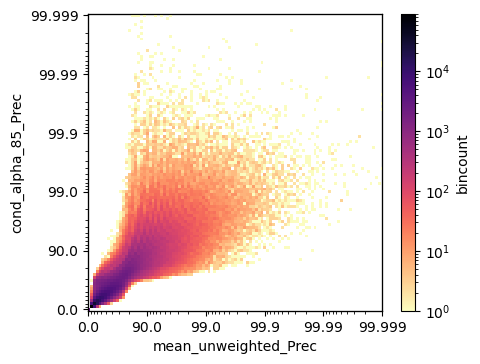

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4.8, 3.7))
jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = ax)
plt.tight_layout()

## mcs bin fraction

(<Axes: xlabel='mean_unweighted_Prec', ylabel='cond_alpha_85_Prec'>,
 <matplotlib.colorbar.Colorbar at 0x151be31441c0>)

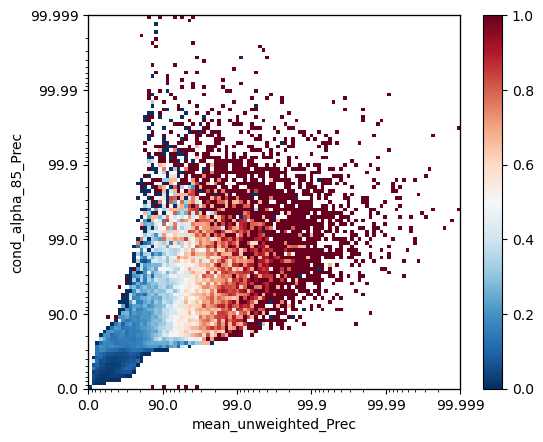

In [22]:
%matplotlib inline
data, noise, count = jd.get_mcs_bin_fraction(region_mask = ocean, bin_noise_treshold= 1)
jd.plot_data(data, noise, vbds = (0,1))

(<Axes: xlabel='mean_unweighted_Prec', ylabel='cond_alpha_85_Prec'>,
 <matplotlib.colorbar.Colorbar at 0x151be336c0a0>)

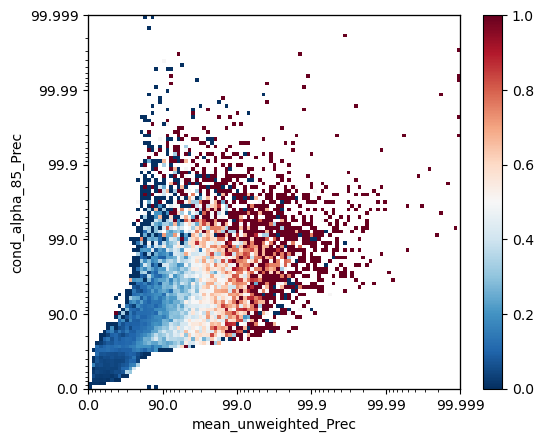

In [23]:
%matplotlib inline
data, noise, count = jd.get_mcs_bin_fraction(region_mask = land, bin_noise_treshold= 1)
jd.plot_data(data, noise, vbds = (0,1))

/scratchx/mcarenso/ipykernel_3595362/2671706089.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


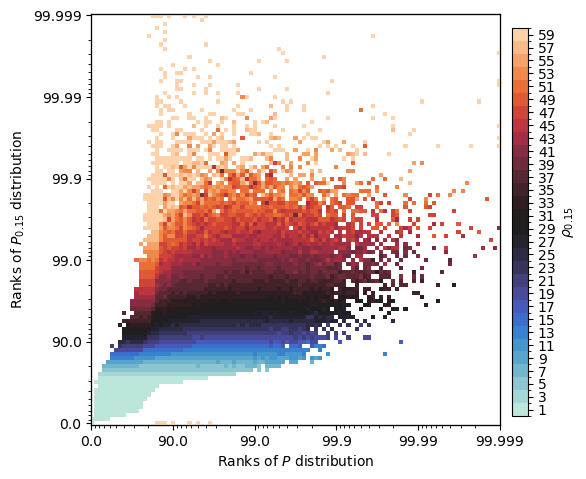

In [24]:
fig, ax  = plt.subplots(figsize = (5.35, 4.85))

cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 62, 1)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar = jd.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_85', mask = np.logical_or(land, ocean), cmap = cmap, norm = norm, fig = fig, ax = ax)
cbar.remove()

# ax.set_title(r"$\rho_{0.5} $ for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=values, spacing='proportional')

cbar.set_label(r'$\rho_{0.15} $')
fig.tight_layout()
plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')

/scratchx/mcarenso/ipykernel_3595362/2393184920.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


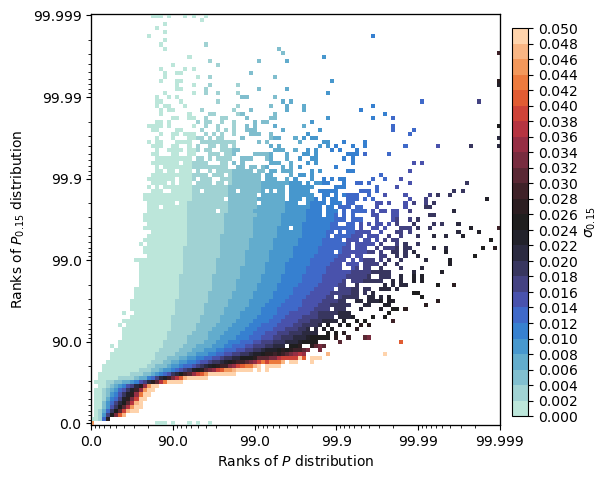

In [12]:
fig, ax  = plt.subplots(figsize = (5.35, 4.85))

cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.05+0.001, 0.001)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]


norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', mask = np.logical_or(land, ocean), cmap = cmap, norm = norm, fig = fig, ax = ax)
cbar.remove()

# ax.set_title(r"$\sigma_{0.5} $ for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=boundaries, spacing='proportional')

cbar.set_label(r'$\sigma_{0.15}$')
plt.tight_layout()
plt.savefig('discrete_surface_ratio_on_joint_dist.png', bbox_inches='tight')

## normalized density

TypeError: The number of func parameters=3 must not exceed the number of data points=2

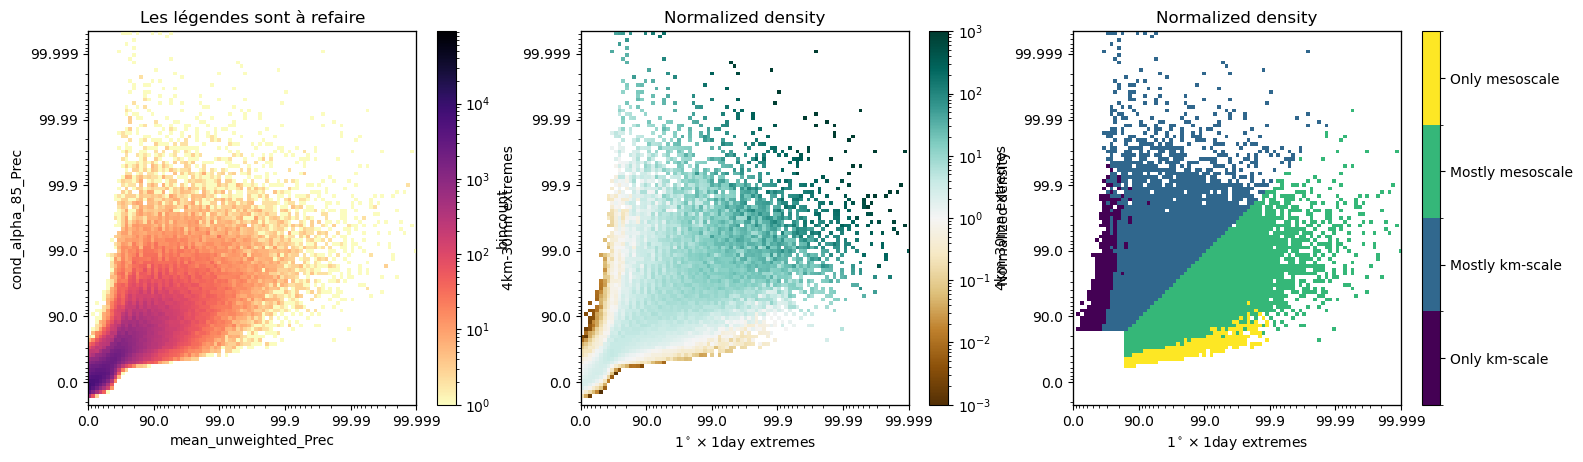

In [25]:
%matplotlib inline

fig, axs = plt.subplots(1, 3, figsize=(3.75*4.8, 4.85))

jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = axs[0])
axs[0].set_title("Les légendes sont à refaire")
jd.plot(mask = False, branch=False, fig = fig, ax = axs[1])
jd.plot(mask = True, branch = True, fig = fig, ax = axs[2])
plt.tight_layout()

Convective only
figure size = 15 3.25
Mostly convective
figure size = 15 3.25
Mostly mesoscale
figure size = 15 3.25
Mesoscale only
figure size = 15 3.25


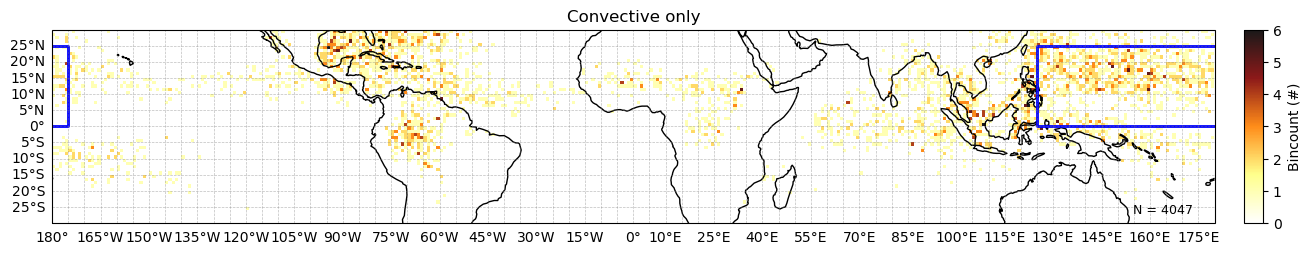

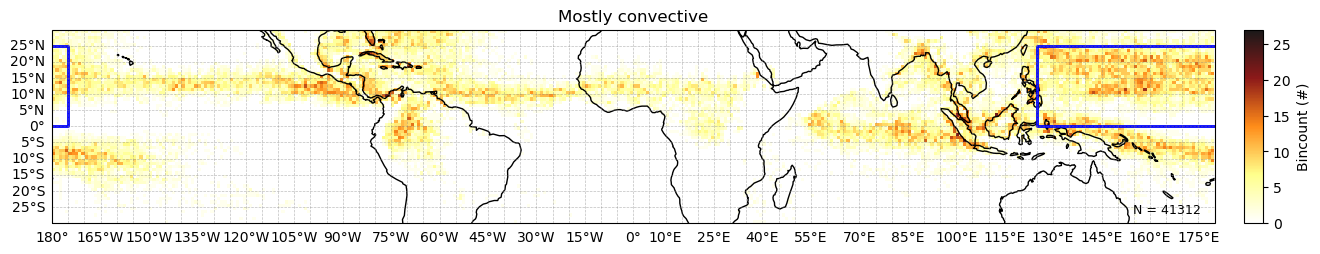

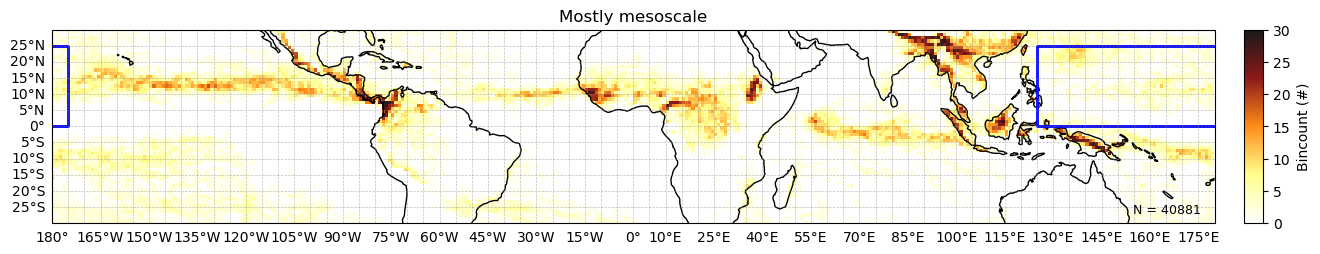

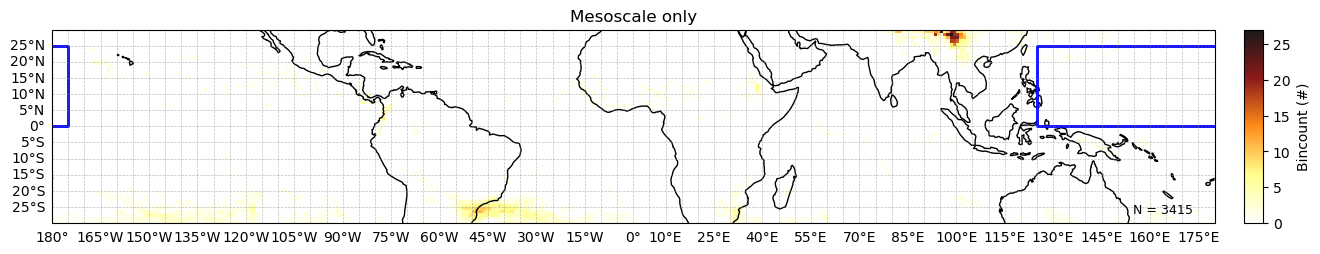

In [15]:
import cartopy.crs as ccrs
import os 
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

jd.make_mask()

mask_all = [jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90]
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'
figdir = ''

# rank  = 2 # 2 , 3,4

# if rank == 1 : 
#     rank_min, rank_max = 90, 99
# elif rank == 2 :
#     rank_min, rank_max = 99, 99.9
# elif rank == 3 :
#     rank_min, rank_max = 99.9, 99.99
# elif rank == 4 :
#     rank_min, rank_max = 99.99, 100

rank_conv_min = 90
rank_acc_min = 90

mask_rank_conv = np.outer(jd.dist1.ranks >= 0, jd.dist2.ranks >= rank_conv_min)
mask_rank_acc = np.outer(jd.dist1.ranks >= rank_acc_min , jd.dist2.ranks >= 0)
            
mask_rank_all = [mask_rank_conv, mask_rank_conv, mask_rank_acc, mask_rank_acc]

for mask,mask_rank, mask_name,mask_label in zip(mask_all,mask_rank_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_ranked = np.logical_and(mask, mask_rank)
    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask_ranked)
    # mask_yxt_ocean = np.logical_and(mask_yxt, ocean)
    ax, cbar = jd.make_map(mask_yxt, data = None)

    # lon_min, lon_max = 215, 280 #gr.lon_slice.start , gr.lon_slice.stop
    # lat_min, lat_max = 5, 20#gr.lat_slice.start, gr.lat_slice.stop
    # ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
    #             [lat_min, lat_min, lat_max, lat_max, lat_min],
    #             color='red', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Eastern Pacific ITCZ")
    lon_min, lon_max = 125, 185 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 25#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='blue', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific Warmpool")
    
    # ax.legend()
    
    ax.set_title(mask_name)

    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')
    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

## MCS Morpho

In [9]:
## Cleans and computes growth rate and s_max
# output_file_path = st.file_storms  
# ds_storms = xr.open_dataset(output_file_path)
# ds_storms['norm_growth_rate'] = ds_storms['growth_rate'] / ds_storms['s_max']
# ds_storms['growth_rate'] = ds_storms['growth_rate'].where((ds_storms['norm_growth_rate'] >= 0) & (ds_storms['norm_growth_rate'] <= 1) & (ds_storms['r_squared'] >= 0.8) , np.nan)
# ds_storms['s_max'] = ds_storms['s_max'].where((ds_storms['norm_growth_rate'] >= 0) & (ds_storms['norm_growth_rate'] <= 1) & (ds_storms['r_squared'] >= 0.8) , np.nan)
# ds_storms['norm_growth_rate'] = ds_storms['norm_growth_rate'].where((ds_storms['norm_growth_rate'] >= 0) & (ds_storms['norm_growth_rate'] <= 1), np.nan)

# os.remove(output_file_path)
# ds_storms.to_netcdf(output_file_path)

In [ ]:
# # Propagate mcs info to grid
# jd.add_mcs_var_from_labels("growth_rate", norm_rel_surf = 'lin', compat='override')
# jd.add_mcs_var_from_labels("norm_growth_rate", norm_rel_surf = 'lin', compat='override')
# jd.add_mcs_var_from_labels("s_max", norm_rel_surf = 'lin', compat='override')
# jd.add_mcs_var_from_labels("duration", norm_rel_surf = 'lin', compat='override')
# jd.add_mcs_var_from_labels("vavg", norm_rel_surf = 'lin', compat='override')

In [13]:
# grid_surf = gr.grid_surface
# caracteric_length = np.sqrt(grid_surf)*1000*np.sqrt(2)
# caracteristic_time = caracteric_length[:,:,np.newaxis]/mcs.vavg_surf_adj
# duration_seconds = mcs.duration_surf_adj*7200
# stationary_time = xr.where(duration_seconds>caracteristic_time, caracteristic_time, duration_seconds)
# mcs["stationary_time"]=stationary_time
# file_mcs = gr.get_var_ds_file("MCS_label")
# import os 
# os.remove(file_mcs)
# mcs.to_netcdf(file_mcs)

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


In [38]:
mcs = gr.get_var_id_ds("MCS_label")

In [39]:
def denormalize(x, min_val, max_val):
        """"
        for optimzing in min-max standardize space
        """
        return x * (max_val - min_val) + min_val

/home/mcarenso/code/tempest/tempest/joint_distrib.py:1092: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


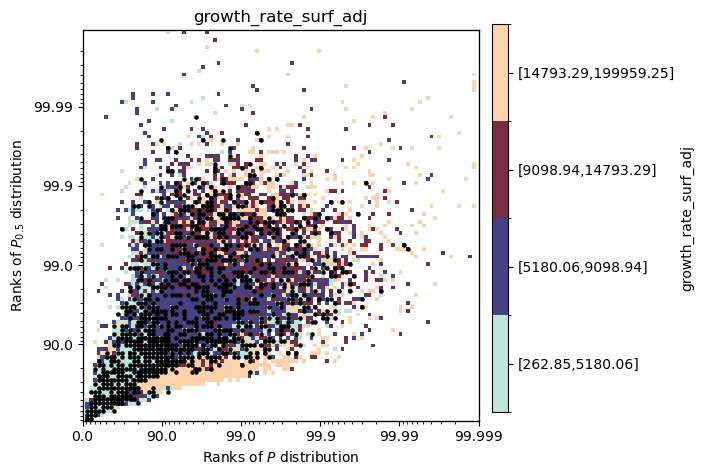

In [40]:
var_id = "growth_rate_surf_adj"
var_cond_list = [0, 0.0246234674168912, 0.044247659885942765, 0.07276269238223437, 1]
func = "MCS"
stipple_threshold=0.1
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold, figsize = (5.23, 4.85))

/home/mcarenso/code/tempest/tempest/joint_distrib.py:1087: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


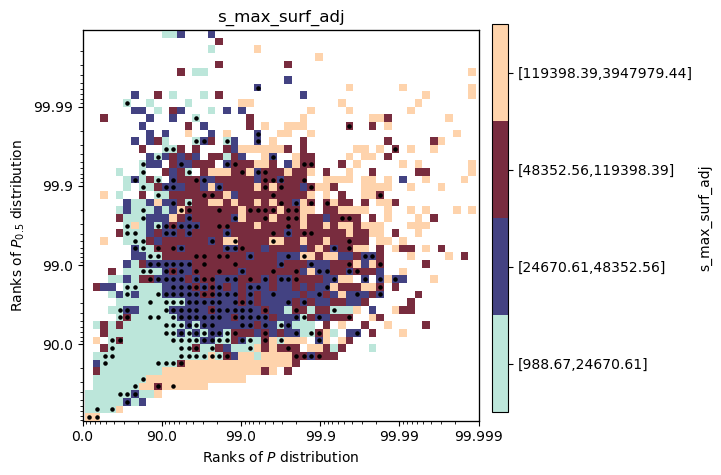

In [48]:
var_id = "s_max_surf_adj"
var_cond_list = [0, 0.006, 0.012, 0.03, 1]
func = "MCS"
stipple_threshold=0.1
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold, figsize = (5.23, 4.85))

/home/mcarenso/code/tempest/tempest/joint_distrib.py:1087: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


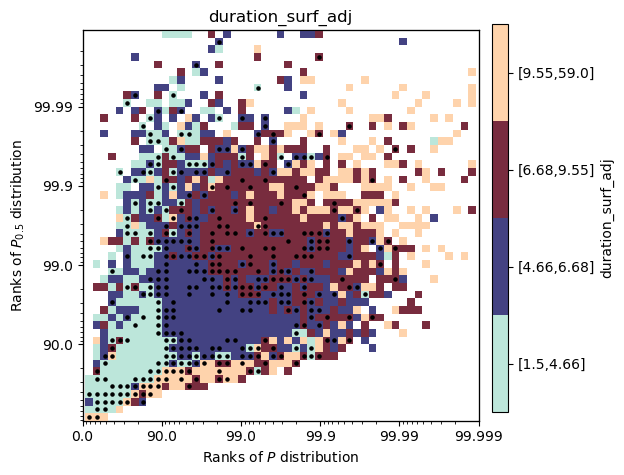

In [66]:
var_id = "duration_surf_adj"
var_cond_list = [0, 0.055, 0.09, 0.14, 1]
func = "MCS"
stipple_threshold=0.1
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold, figsize = (5.23, 4.85))

/home/mcarenso/code/tempest/tempest/joint_distrib.py:1087: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


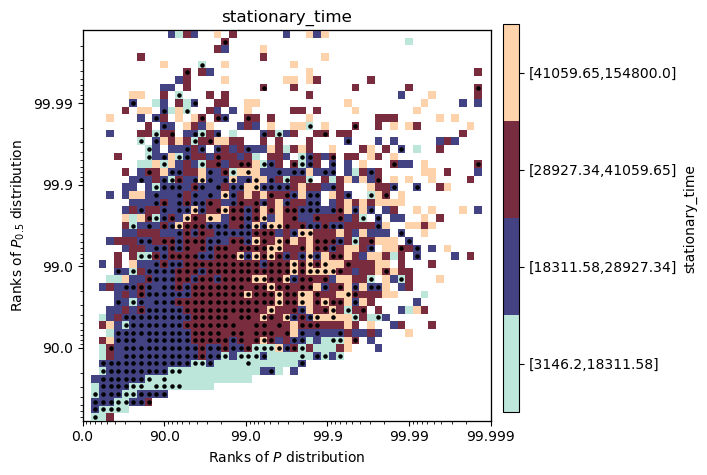

In [24]:
var_id = "stationary_time"
var_cond_list = [0,0.1, 0.17, 0.25, 1]
func = "MCS"
stipple_threshold=0.2
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in vaZr_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold)

/home/mcarenso/code/tempest/tempest/joint_distrib.py:1087: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


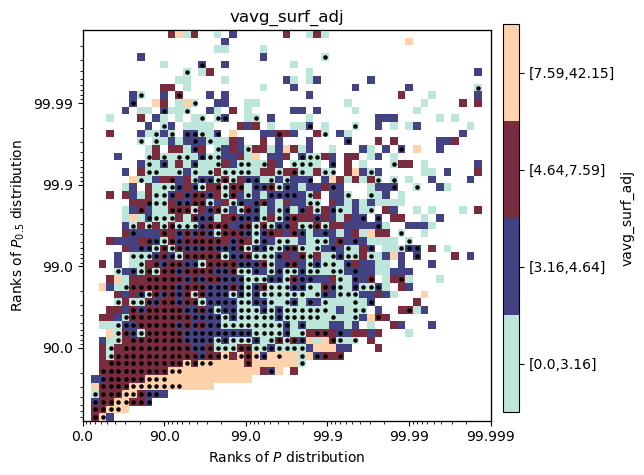

In [26]:
var_id = "vavg_surf_adj"
var_cond_list = [0, 0.075, 0.11, 0.18, 1]
func = "MCS"
stipple_threshold=0.2
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold)